In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm                   # for colormaps
import matplotlib as mpl                    # more general items
from matplotlib.gridspec import GridSpec    # formatting subplots
import networkx as nx
import pandas as pd

# physical review E column width in inches
col_width = 3+3/8
plt.style.use("style.mplstyle") # closer to LaTeX

# random graph model
from Load_MD_Data import *
# MD summary statistics (global_data_avg,skeleton_data_avg)
from HydrocarbonSimulationHelpers import *
# 10 Reaction Model / previous work
Deg_10RM = pd.read_csv('../../Data/processed_MD/Degrees_predictions_10reac.csv',index_col=0)
# molecule size distribution from MD
component_data = pd.read_csv('../../Data/processed_MD/SkeletonComp.csv',index_col=0)
component_data.loc[:,['GiantDist','CompSizeDist','CompSizeStd']] = \
                        component_data.loc[:,['GiantDist','CompSizeDist','CompSizeStd']].map(lambda string: 
                        np.array([float(word) for word in string.strip('[]').replace(',',' ').replace('\n','').split()]))

# Data Collection

Only run the next cell to sample for new component size samples. Otherwise run the cell after to simply load summary statistics of the random graph models. The sampling methods for this data take a few hours in total.
Here five models are considered:
- Previous work: ten-reaction model from https://pubs.aip.org/aip/jcp/article/158/2/024101/2868089/Predicting-molecule-size-distribution-in
- Model 1: Configuration model
- Model 2: Disjoint Loop Model
- Model 3: Disjoint Loop Model + Assortativity Correction
- Proposed Model: Disjoint Loop Model + Assortativity Correction (parameters from reaction model)


In [2]:
# initialization data
# parameters without fit
p3_vec  = global_data_avg['CDegDist'].apply(lambda x: x[3]/(x[3]+x[4]))
phh_vec = 2*global_data_avg['Nhh']/(2*global_data_avg['Nhh']+global_data_avg['Nch'])
# loop parameters
Count_vec = skeleton_data_avg['LoopCountDist'].apply(lambda x: sum(x*np.arange(len(x))))
Len_vec = skeleton_data_avg['LoopSizeDist']

# blank dataframe for giant components
# col. format: model_item 
#   models: previous work / ten-reaction model (10RM), Model 1 (Conf), Model 2 (Loop), Model 3 (Rewire), Proposed Model (Proposed)
#   items: sample distribution (dist), mean (SampleMean), and standard dev. (SampleStd), 
#          frac in giant using generating function approach (GiantGF)
giant_df = pd.DataFrame(columns=['10RM_dist', '10RM_SampleMean', '10RM_SampleStd', '10RM_GiantGF',\
                                 'Conf_dist', 'Conf_SampleMean', 'Conf_SampleStd', 'Conf_GiantGF',\
                                 'Loop_dist', 'Loop_SampleMean', 'Loop_SampleStd', 'Loop_GiantGF',\
                                 'Rewire_dist', 'Rewire_SampleMean', 'Rewire_SampleStd', 'Rewire_GiantGF',\
                                 'Proposed_dist', 'Proposed_SampleMean', 'Proposed_SampleStd', 'Proposed_GiantGF'],
                        index=Indices)

# can't draw enough loop nodes - for loop dense data
# just try again if so
xxx = 0 # number of failed attempts - ideally less than 1%
def repeat_draw(Nc,Nh,phh,p3,LamN,LoopLenDist):
    global xxx
    while True: 
        HCN = randHCnet_from_params(Nc,Nh,phh,p3,LamN,LoopLenDist)
        if not HCN.eFlag:   return HCN
        else:               xxx +=1

for i,idx in enumerate(Indices):
    print(idx)
    ##### get params. to sample #####
    # general params
    Nc, Nh = int(global_data_avg.loc[idx,'Nc']), int(global_data_avg.loc[idx,'Nh'])
    HCR, Temp = Nh/Nc, global_data_avg.loc[idx,'Temp']

    # ten-reaction model degree distribution - CDF for sampling
    DegDist10RM = np.array(Deg_10RM.loc[idx][:5]/Nc)
    DegDist10RM_CDF = np.cumsum(DegDist10RM)

    # deg. dist. params w/ and w/o fit
    p3, phh = p3_vec.loc[idx],phh_vec.loc[idx]
    p3_fit,phh_fit = p3_from_fit(HCR,Temp),phh_from_fit(HCR,Temp)

    # loop params w/ fit
    Lam = Count_vec.loc[idx]/Nc                 # expected number of loops
    LoopSizeDist = Len_vec.loc[idx]           # loop length distribution
    # w/o fit
    LamPhi_fit       = loop_from_fit(HCR,Temp)                      # lambda*phi_k dist., sum to lambda, normalize to loop length dist
    Lam_fit          = sum(LamPhi_fit)
    LoopSizeDist_fit = LamPhi_fit/Lam_fit


    ##### Sample random graphs #####
    # no rewiring - 10RM and Models 1/2
    Trials = 100000
    tenRM_GCC_Samples = np.zeros(Trials)
    Conf_GCC_Samples = np.zeros(Trials)
    Loop_GCC_Samples = np.zeros(Trials)
    for j in range(Trials):
        if j % 1000 == 0:
            print('{:4.1f}'.format(j/2/Trials*100) + '%\r',end='')
        # 10RM
        deg_seq = DegDist10RM_CDF.searchsorted(np.random.random(Nc))
        HCN=nx.Graph()
        HCN.add_nodes_from(np.arange(Nc))
        HCN.add_edges_from(DisjointLoopModel(deg_seq)[1]) # Conf. Model is Disjoint loop model w/o loops
        tenRM_GCC_Samples[j] = max([len(CC) for CC in nx.connected_components(HCN)])
        # Conf. model - new deg. dist.
        Conf_GCC_Samples[j] = randHCnet_from_params(Nc,Nh,phh,p3).GCC_C()
        # Disjoint loop model w/o rewire
        Loop_GCC_Samples[j] = repeat_draw(Nc,Nh,phh,p3,Lam,LoopSizeDist).GCC_C()

    # rewiring schemes
    iters = 50                               # sample multiple times from rewiring scheme at equilibrium - save computation time
    Rewire_GCC_Samples = np.zeros(Trials)
    Proposed_GCC_Samples = np.zeros(Trials)
    # sample assortativity to measure rewire effectiveness
    # goal below .01 as an assortative version of disjoint loop model gets to .1
    assort_per = 5 # a bit more balance on assortativity measurement vs. cost
    assort_1 = np.zeros(Trials//assort_per)
    assort_2 = np.zeros(Trials//assort_per)

    LamNMax = max(Lam,Lam_fit)*Nc
    NRewire = round(2*Nc*LamNMax  + 500) # initial rewire length
    Gap = 50
    for j in range(Trials//iters):
        if j % (1000//iters) == 0:
            print('{:4.1f}'.format(j/2/Trials*100*iters+50) + '%\r',end='')

        # Disjoint Loop Model + Assort Correct
        # no param fit.
        HCN1 = repeat_draw(Nc,Nh,phh,p3,Lam,LoopSizeDist) # sample graph
        HCN1.assort_correct(NRewire)                       # initial assortativity correction
        # param. fit
        HCN2 = repeat_draw(Nc,Nh,phh_fit,p3_fit,Lam_fit,LoopSizeDist_fit)
        HCN2.assort_correct(NRewire)
        for k in range(iters):
            # index in array
            samp_idx = j*iters+k
            # no fit
            HCN1.assort_correct(Gap)
            Rewire_GCC_Samples[samp_idx] = HCN1.GCC_C()
            # fit
            HCN2.assort_correct(Gap)
            Proposed_GCC_Samples[samp_idx] = HCN2.GCC_C()
            if samp_idx % assort_per == 0:
                assort_1[samp_idx//assort_per] = HCN1.assort_C()
                assort_2[samp_idx//assort_per] = HCN2.assort_C()

    ##### potential sample errors #####
    # want to stay less than .01 in abs.
    print('Model 3 Assort:','{:7.4f}'.format(np.mean(assort_1)),u"\u00B1",'{:5.4f}'.format(np.std(assort_1)/np.sqrt(Trials//assort_per)))
    print('Model 4 Assort:','{:7.4f}'.format(np.mean(assort_2)),u"\u00B1",'{:5.4f}'.format(np.std(assort_2)/np.sqrt(Trials//assort_per)))
    # want less than Trials/100 = 1000 failures
    print('Failures to draw:',xxx)
    xxx=0 # reset for next


    ##### Compute summary data for dataframe - bit of a mess #####
    giant_df.loc[idx,'10RM_dist'] = np.array([sum(tenRM_GCC_Samples == i) for i in range(Nc+1)])/Trials
    giant_df.loc[idx,'10RM_SampleMean'] = np.mean(tenRM_GCC_Samples)
    giant_df.loc[idx,'10RM_SampleStd']  = np.std(tenRM_GCC_Samples)
    giant_df.loc[idx,'Conf_dist'] = np.array([sum(Conf_GCC_Samples == i) for i in range(Nc+1)])/Trials
    giant_df.loc[idx,'Conf_SampleMean'] = np.mean(Conf_GCC_Samples)
    giant_df.loc[idx,'Conf_SampleStd']  = np.std(Conf_GCC_Samples)
    giant_df.loc[idx,'Loop_dist'] = np.array([sum(Loop_GCC_Samples == i) for i in range(Nc+1)])/Trials
    giant_df.loc[idx,'Loop_SampleMean'] = np.mean(Loop_GCC_Samples)
    giant_df.loc[idx,'Loop_SampleStd']  = np.std(Loop_GCC_Samples)
    giant_df.loc[idx,'Rewire_dist'] = np.array([sum(Rewire_GCC_Samples == i) for i in range(Nc+1)])/Trials
    giant_df.loc[idx,'Rewire_SampleMean'] = np.mean(Rewire_GCC_Samples)
    giant_df.loc[idx,'Rewire_SampleStd']  = np.std(Rewire_GCC_Samples)
    giant_df.loc[idx,'Proposed_dist'] = np.array([sum(Proposed_GCC_Samples == i) for i in range(Nc+1)])/Trials
    giant_df.loc[idx,'Proposed_SampleMean'] = np.mean(Proposed_GCC_Samples)
    giant_df.loc[idx,'Proposed_SampleStd']  = np.std(Proposed_GCC_Samples)

    ##### Generating function methods #####
    giant_df.loc[idx,'10RM_GiantGF'] = DisjointLoop_GF(DegDist10RM,tol=1e-15).Giant() # not sure why lower tol, doesn't matter ignoring it
    giant_df.loc[idx,'Conf_GiantGF'] = randHCnet_GF(HCR,phh,p3).Giant()
    giant_df.loc[idx,'Loop_GiantGF'] = randHCnet_GF(HCR,phh,p3,Lam,LoopSizeDist).Giant()
    giant_df.loc[idx,'Rewire_GiantGF'] = randHCnet_GF(HCR,phh,p3,Lam,LoopSizeDist,Rewire=True).Giant()
    giant_df.loc[idx,'Proposed_GiantGF'] = randHCnet_GF(HCR,phh_fit,p3_fit,Lam_fit,LoopSizeDist_fit,Rewire=True).Giant()
    
# when it's sufficiently low for no giant prediction
for key in ['10RM_GiantGF','Conf_GiantGF','Loop_GiantGF','Rewire_GiantGF','Proposed_GiantGF']:
    giant_df[key]=giant_df[key].apply(lambda x: abs(x*(x>1e-3)))

C2H6_3300K


KeyboardInterrupt: 

### Save / load csv component data

In [2]:
### uncomment one of the following ###

# saving to csv
# giant_df.to_csv('../../Data/Random Graphs/GiantComponent.csv') 

# loading sampling and generating funtion from csv
giant_df = pd.read_csv('../../Data/Random_Graphs/GiantComponent.csv',index_col=0)
# read lists from strings
giant_df[ ['10RM_dist','Conf_dist','Loop_dist','Rewire_dist','Proposed_dist'] ] = \
                            giant_df[ ['10RM_dist','Conf_dist','Loop_dist','Rewire_dist','Proposed_dist'] ].map(lambda x: 
                            [float(s) for s in x.strip('[]').replace('\n','').split(' ')])

# Large Components Plots

Plots for the giant component predicted by each model. This is split into four cells. Cell 1 produces Fig. 1 comparing Previous Work, MD, and Proposed Model for a single set of initial conditions. Cell 2 generates the giant component data for the results section (Fig. 12). Cells 3 and 4 create histograms for the supplementary giant component distributions given by MD and Proposed Model for all initial conditions. 

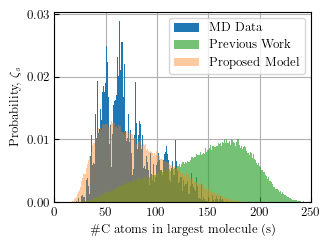

In [4]:
# Histogram for size distribution of the giant connected component Proposed Model vs. 10RM vs. MD
plt.figure(figsize = (col_width,0.75*col_width))
plt.bar(np.arange(321),component_data['GiantDist'].loc['C4H10_3600K_1120at'],width=1,alpha=1,color='C0')
plt.bar(np.arange(321),giant_df['10RM_dist'].loc['C4H10_3600K_1120at'],width=1,alpha=.65,color='C2')
plt.bar(np.arange(321),giant_df['Proposed_dist'].loc['C4H10_3600K_1120at'],width=1,alpha=.4,color='C1')
plt.xlabel('\#C atoms in largest molecule (s)')
plt.xlim([0,250])
plt.ylabel('Probability, $\zeta_s$')
plt.yticks([0,0.01,0.02,0.03])
plt.grid('on')
plt.legend(['MD Data', 'Previous Work', 'Proposed Model'])
plt.tight_layout()
plt.savefig('../../Figures/Components/Hist_Compare_C4H10_3600K_1120at.pdf')

### Giant Component: Primary Figure

Two rows.
- Row 1: sample histograms for the giant component size distribution to compare MD to Proposed Model
- Row 2: scatter plot of fraction of nodes in giant component in all models

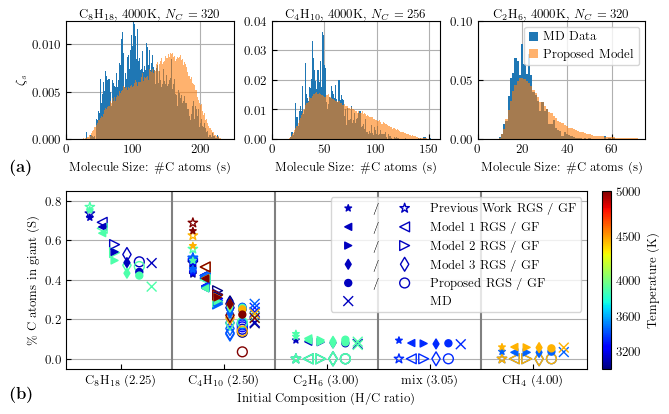

In [7]:
### setup plot ### 
Temp_vec = global_data_avg['Temp']
HCR_vec = global_data_avg['Nh']/global_data_avg['Nc']
Nc_vec = global_data_avg['Nc']
# need preset colors, edgecolors does not accept arbitrary numbers
c = [cm.jet((t - 3200)/(5000-3200)) for t in Temp_vec] # scale to 0,1 and apply color scheme

# HCR -> on integer lattice for even spacing
aux = HCR_vec.copy()
for i,hcr in enumerate([2.25,2.5,3,3.05,4]):
    aux[HCR_vec==hcr] = i

# empty plot
fig = plt.figure(figsize=(2*col_width,5/4*col_width))
gs = GridSpec(2, 3, figure=fig,height_ratios=[.4,.6])
axbig = fig.add_subplot(gs[1, :])


### plot scatter data (Fig. 12b) ###
msize = 50
dx = .12
width=1
# 10RM
h_10RMGF = axbig.scatter(aux-2.5*dx,giant_df.loc[Indices,'10RM_GiantGF'],marker='*',edgecolors=c,s=msize,facecolors='none',lw=width)
h_10RMSa = axbig.scatter(aux-2.5*dx,giant_df.loc[Indices,'10RM_SampleMean'].to_numpy()/Nc_vec,marker='*',s=msize/2,c=c)
# model 1
h_ConfGF = axbig.scatter(aux-1.5*dx,giant_df.loc[Indices,'Conf_GiantGF'],marker='<',edgecolors=c,s=msize,facecolors='none',lw=width)
h_ConfSa = axbig.scatter(aux-1.5*dx,giant_df.loc[Indices,'Conf_SampleMean'].to_numpy()/Nc_vec,c=c,marker='<',s=msize/2)
# model 2
h_LoopGF =axbig.scatter(aux-.5*dx,giant_df.loc[Indices,'Loop_GiantGF'],marker='>',edgecolors=c,s=msize,facecolors='none',lw=width)
h_LoopSa = axbig.scatter(aux-.5*dx,giant_df.loc[Indices,'Loop_SampleMean'].to_numpy()/Nc_vec,c=c,marker='>',s=msize/2)
# model 3
h_RewireGF = axbig.scatter(aux+.5*dx,giant_df.loc[Indices,'Rewire_GiantGF'],marker='d',edgecolors=c,s=msize,facecolors='none',lw=width)
h_RewireSa = axbig.scatter(aux+.5*dx,giant_df.loc[Indices,'Rewire_SampleMean'].to_numpy()/Nc_vec,c=c,marker='d',s=msize/2)
# proposed model
h_ProposedGF = axbig.scatter(aux+1.5*dx,giant_df.loc[Indices,'Proposed_GiantGF'],facecolors='none',edgecolors=c,marker='o',s=msize,lw=width)
h_ProposedSa = axbig.scatter(aux+1.5*dx,giant_df.loc[Indices,'Proposed_SampleMean'].to_numpy()/Nc_vec,c=c,marker='o',s=msize/2)
# MD data
p = plt.scatter(aux+2.5*dx,component_data['Giant'][Indices]/Nc_vec,c=c,marker='x',s=msize,lw=width)
# blank plot
b = plt.scatter(0,0,marker='none')

### Formatting
# legend - formatted funny to include handles, slashes, etc.
plt.legend(handles=[h_10RMSa,h_ConfSa,h_LoopSa,h_RewireSa,h_ProposedSa,p,h_10RMGF,h_ConfGF,h_LoopGF,h_RewireGF,h_ProposedGF,b],
    labels=['/','/','/','/','/','','  Previous Work RGS / GF','  Model 1 RGS / GF','  Model 2 RGS / GF',
            '  Model 3 RGS / GF','  Proposed RGS / GF','  MD'],
    ncol=2,columnspacing=1,handletextpad=1)

# axes
plt.xticks(range(5),[r'${\rm C}_8{\rm H}_{18}$ (2.25)',r'${\rm C}_4{\rm H}_{10}$ (2.50)',r'${\rm C}_2{\rm H}_6$ (3.00)',
                     'mix (3.05)',r'${\rm CH}_4$ (4.00)'])#,rotation=60)
plt.xlabel('Initial Composition (H/C ratio)')
plt.ylabel('\% C atoms in giant (S)')
plt.ylim([-0.05,0.85])

# grid lines better in between as separator
plt.grid(axis='y')
for pos in range(4):
    plt.axvline(x=.5+pos,c='grey')

# colorbar
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=3000, vmax=5000)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),ax=axbig, pad=0.025,fraction=0.075)
Temps = np.array([3200,3600,4000,4500,5000])
cbar.set_ticks(Temps)
cbar.set_ticklabels(Temps)
cbar.set_label('Temperature (K)')



### histograms ###
ax = []
# ('C4H10_4000K',r'${\rm C}_4 {\rm H}_{10}$ 4000K')
for i,x in enumerate([# ('C4H10_3600K_1120at',r'${\rm C}_4 {\rm H}_{10}$ 3600K',225,.03),
                      ('C8H18_4000K_1040at',r'${\rm C}_8 {\rm H}_{18}$, 4000K',250,.0125),
                      ('C4H10_4000K',r'${\rm C}_4 {\rm H}_{10}$, 4000K',160,.04), 
                      ('C2H6_4000K_1280at',r'${\rm C}_2 {\rm H}_{6}$, 4000K',75,.1),
                      # ('CH4_4500K',r'${\rm C} {\rm H}_{4}$ 4500K',30,.25)
                      ]):
    idx,label,s_max,y_max = x
    ax.append(fig.add_subplot(gs[0, i]))
    ax[-1].grid()
    
    MD_Dist = component_data['GiantDist'].loc[idx]
    Proposed_Dist = giant_df['Proposed_dist'].loc[idx]

    # plot histograms
    ax[-1].bar(np.arange(len(MD_Dist)),MD_Dist,width=1,alpha=1)
    ax[-1].bar(np.arange(len(Proposed_Dist)),Proposed_Dist,width=1,alpha=.6)
    if i == 2:
        ax[-1].legend(['MD Data','Proposed Model'],loc='upper right',handlelength=0.7,handletextpad=0.4)

    ax[-1].set_xlim([0,s_max])
    ax[-1].set_xlabel('Molecule Size: \#C atoms (s)')
    if i == 2:
        ax[-1].set_yticks([0,0.05,0.1])
    ax[-1].set_ylim([0,y_max])
    if not i: ax[-1].set_ylabel(r'$\zeta_s$')
    Nc = global_data_avg['Nc'].loc[idx]
    atoms_str = r'$N_C={:d}$'.format(int(Nc))    
    b = idx[:2] == 'C8'
    ax[-1].set_title(label+', '+atoms_str,fontsize=9, pad=2)

    


### Print out ###
plt.tight_layout()
gs.update(wspace=.225)
axbig.text(-1.075,0.95,'\\textbf{(a)}',fontsize=12)
axbig.text(-1.075,-.2,'\\textbf{(b)}',fontsize=12)
plt.savefig('../../Figures/Components/GiantComp+Hists.pdf')

### Giant component size distribution for ${\rm C}_4{\rm H}_{10}$ and ${\rm C}_8{\rm H}_{18}$ data

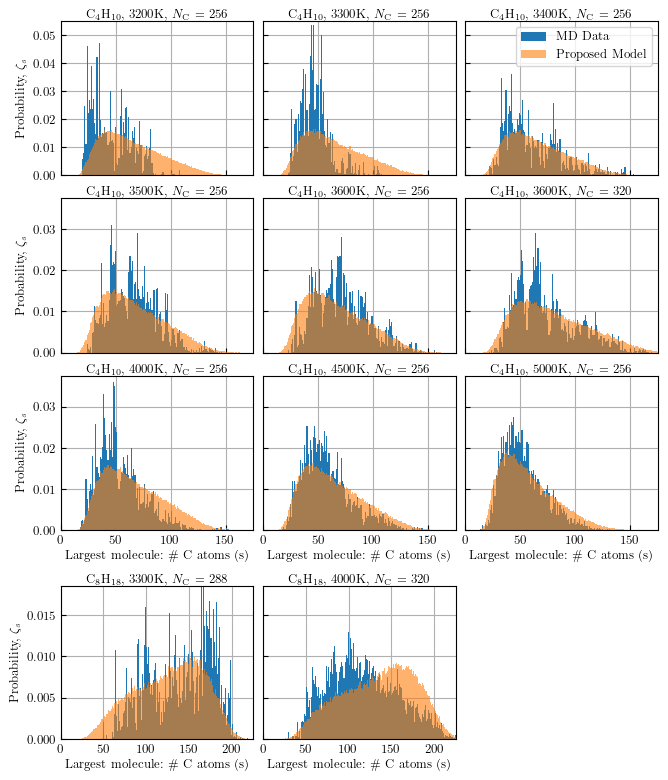

In [8]:
### Histograms for the giant connected component for C4H10 and C8H18 ###
fig = plt.figure(figsize=(2*col_width,7/3*col_width))
gs = GridSpec(2,1,height_ratios=(0.75,0.225),figure = fig)

gs0 = mpl.gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=gs[0],hspace=.15,wspace=0.05)
gs1 = mpl.gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=gs[1],wspace=0.05)

for i,idx in enumerate(['C4H10_3200K','C4H10_3300K','C4H10_3400K',
                        'C4H10_3500K','C4H10_3600K','C4H10_3600K_1120at',
                        'C4H10_4000K','C4H10_4500K','C4H10_5000K',
                        'C8H18_3300K','C8H18_4000K_1040at']):
    pos=(i//3,i%3) # position index of subplot
    if pos[0] < 3: # C4H10
        ax = fig.add_subplot(gs0[pos])
    else:
        ax = fig.add_subplot(gs1[pos[1]])

    Nc = int(global_data_avg['Nc'].loc[idx])
    temp = int(global_data_avg['Temp'].loc[idx])

    # plot histograms
    ax.bar(np.arange(Nc+1),component_data['GiantDist'].loc[idx],width=1,alpha=1)
    ax.bar(np.arange(Nc+1),giant_df['Proposed_dist'].loc[idx],width=1,alpha=.6)
    if pos == (0,2): ax.legend(['MD Data','Proposed Model'],loc='upper right')
    ax.grid()

    # only show leftmost yaxis
    if pos[1]==0: # col 0
        ax.set_ylabel('Probability, $\zeta_s$')
    else: ax.set_yticklabels([])

    if idx[:5] == 'C4H10':
        ax.set_title(r'${\rm C}_4{\rm H}_{10}$, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)
        ax.set_xlim([0,175])
        if pos[0]==0:ax.set_ylim([0,0.055])
        else: ax.set_ylim([0,0.0375])
        if pos[0]==2: # row 3
            ax.set_xlabel('Largest molecule: \# C atoms (s)',labelpad=2)
        else: ax.set_xticklabels([])
    else:
        ax.set_title(r'${\rm C}_8{\rm H}_{18}$, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)
        ax.set_xlabel('Largest molecule: \# C atoms (s)',labelpad=2)
        ax.set_xlim([0,225])
        ax.set_ylim([0,0.0185])
plt.tight_layout()
plt.savefig('../../Figures/Components/GiantHistsC4,C8.pdf')
plt.show()
plt.close()

### Giant component size distribution for ${\rm C}_2{\rm H}_{6}$, ${\rm C}{\rm H}_{4}$, and mix data

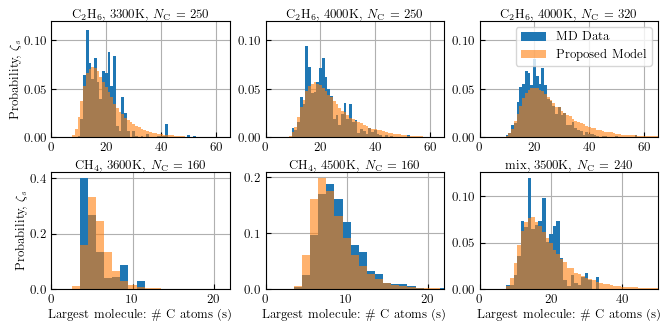

In [9]:
### Histograms for the giant connected component for C2H6, CH4 and mix ###
fig = plt.figure(figsize=(2*col_width,col_width))
gs = GridSpec(2,3,figure = fig)

for i,idx in enumerate(['C2H6_3300K','C2H6_4000K','C2H6_4000K_1280at',
                        'CH4_3600K','CH4_4500K','mix_3500K']):
    pos=(i//3,i%3) # position index of subplot
    ax = fig.add_subplot(gs[pos])

    Nc = int(global_data_avg['Nc'].loc[idx])
    temp = int(global_data_avg['Temp'].loc[idx])

    # plot histograms
    ax.bar(np.arange(Nc+1),component_data['GiantDist'].loc[idx],width=1,alpha=1)
    ax.bar(np.arange(Nc+1),giant_df['Proposed_dist'].loc[idx],width=1,alpha=.6)
    if pos == (0,2) or pos == (3,1): ax.legend(['MD Data','Proposed Model'],loc='upper right')
    ax.grid()

    if pos[0]==1:ax.set_xlabel('Largest molecule: \# C atoms (s)',labelpad=2)
    if pos[1]==0:ax.set_ylabel('Probability, $\zeta_s$',labelpad=2)

    if pos[0] == 0: # row 1 - C2H6
        ax.set_title(r'${\rm C}_2{\rm H}_6$, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)
        ax.set_xlim([0,65])
        ax.set_ylim([0,0.12])
    else:
        if pos[1] == 2: # row 2 col 3 - mix
            ax.set_xlim([0,50])
            ax.set_title(r'mix, 3500K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)
        else: # row 2 col 1/2 - CH4
            ax.set_xlim([0,22])
            ax.set_title(r'${\rm C}{\rm H}_4$, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)

plt.tight_layout()
gs.update(hspace=.3,wspace=.2)
plt.savefig('../../Figures/Components/GiantHistsC,C2,mix.pdf')
plt.show()
plt.close()

# Small Components

Generate 3 figures each in its own cell. Cell 1, 4 small component size distributions and their Wasserstein distance to MD data (Fig. 13). Cells 2 and 3, small component size distribution comparing Previous Work, MD data, and Proposed Model.

First, the small component size distributions are obtained via generating functions in the next cell.

In [10]:
# compute component size distribution and corresponding Wasserstein distances to MD distribution
# No need to save to disk - easy to compute
SmallComps_df = pd.DataFrame(columns=['10RM_dist','10RM_W1',
                                      'DisLoop_dist',
                                      'Proposed_dist','Proposed_W1'],index=Indices)

# parameters without fit
p3_vec  = global_data_avg['CDegDist'].apply(lambda x: x[3]/(x[3]+x[4]))
phh_vec = 2*global_data_avg['Nhh']/(2*global_data_avg['Nhh']+global_data_avg['Nch'])
# loop parameters
Count_vec = skeleton_data_avg['LoopCountDist'].apply(lambda x: sum(x*np.arange(len(x))))
Len_vec = skeleton_data_avg['LoopSizeDist']
Mean_len = skeleton_data_avg['LoopSizeDist'].apply(lambda x: sum(x*np.arange(len(x))))

for i,idx in enumerate(Indices):
    print(idx)
    # Unpack Data
    Nc,Nh = global_data_avg['Nc'].loc[idx],global_data_avg['Nh'].loc[idx]
    Temp =  global_data_avg['Temp'].loc[idx]
    p3,phh = p3_vec.loc[idx],phh_vec.loc[idx]
    # loop params
    Lam = Count_vec.loc[idx]/Nc
    LoopSizeDist = Len_vec.loc[idx]
    # fit params
    p3_fit = p3_from_fit(Nh/Nc,Temp) 
    phh_fit = phh_from_fit(Nh/Nc,Temp)
    LamPhi_fit = loop_from_fit(Nh/Nc,Temp)
    Lam_fit = sum(LamPhi_fit)
    LoopSizeDist_fit = LamPhi_fit/sum(LamPhi_fit)

    # from MD
    Avg_MD = component_data['CompSizeDist'].loc[idx][1:21]
    Avg_MD /= sum(Avg_MD)

    # ten-reaction model
    DD_10RM = Deg_10RM.loc[idx][:5].to_numpy()/Nc
    pi_s_10RM = DisjointLoop_GF(DD_10RM).SmallComponents(2**8)[:20] # conf model -> disjoint loops w/o loops...
    pi_s_10RM/= sum(pi_s_10RM)
    SmallComps_df.loc[idx,'10RM_dist'] = pi_s_10RM
    SmallComps_df.loc[idx,'10RM_W1'] = sum([abs(np.sum(pi_s_10RM[:j]-Avg_MD[:j])) for j in range(1,21)])

    # Disjoint Loop Model
    pi_s_l = randHCnet_GF(Nh/Nc,phh,p3,Lam,LoopSizeDist).SmallComponents(2**8)[:20]
    pi_s_l/= sum(pi_s_l)
    SmallComps_df.loc[idx,'DisLoop_dist'] = pi_s_l

    # Proposed Model
    pi_s_p = randHCnet_GF(Nh/Nc,phh_fit,p3_fit,Lam_fit,LoopSizeDist_fit,Rewire=True).SmallComponents(2**8)[:20]
    pi_s_p/= sum(pi_s_p)
    SmallComps_df.loc[idx,'Proposed_dist'] = pi_s_p
    SmallComps_df.loc[idx,'Proposed_W1'] = sum([abs(np.sum(pi_s_p[:j]-Avg_MD[:j])) for j in range(1,21)])

C2H6_3300K
C2H6_4000K
C2H6_4000K_1280at
C4H10_3200K
C4H10_3300K
C4H10_3400K
C4H10_3500K
C4H10_3600K
C4H10_3600K_1120at
C4H10_4000K
C4H10_4500K
C4H10_5000K
C8H18_3300K
C8H18_4000K_1040at
CH4_3600K
CH4_4500K
mix_3500K


### Wasserstein Error

For Figure 13
- Columns 1 & 2: 4 example small component size distributions
- Column 3: Wasserstein error of previous work and proposed model predicting molecule size distribution from MD

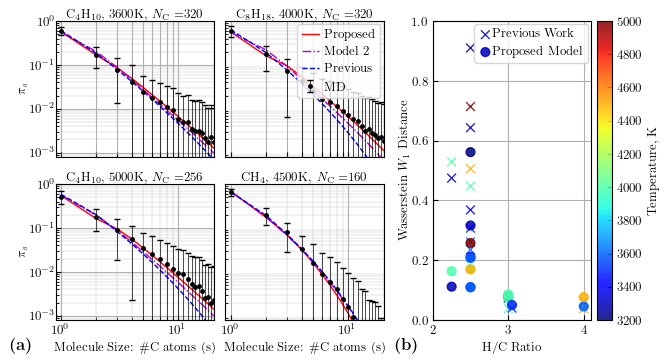

In [13]:
# plot Wasserstein distance
fig = plt.figure(figsize=(2*col_width,1.1*col_width))
gs = GridSpec(1, 2, figure=fig,width_ratios=[.6,.4])
axW = fig.add_subplot(gs[1])

msize = 40
width = 1/2

# 10RM
s1 = axW.scatter(global_data_avg['Nh']/global_data_avg['Nc'],SmallComps_df['10RM_W1'],c=global_data_avg['Temp'],
            cmap='jet',s=msize,alpha=0.85,marker='x',lw=1)
# Proposed
axW.scatter(global_data_avg['Nh']/global_data_avg['Nc'],SmallComps_df['Proposed_W1'],c=global_data_avg['Temp'],
            cmap='jet',s=msize,alpha=0.85) # Proposed Model
axW.set_ylabel('Wasserstein '+r'$W_1$'+' Distance',labelpad=1)
axW.set_xlabel('H/C Ratio')
plt.colorbar(s1,label='Temperature, K',ax=axW, pad=0.025,fraction=0.25)
axW.set_ylim([0,1])
axW.grid(True)
axW.set_xlim([2,4.1])
axW.legend(['Previous Work','Proposed Model'],
           handlelength=1,handletextpad=0.05,borderaxespad=.25)#,borderpad=.25

gs0 = gs[0].subgridspec(2,2,wspace=0.075,hspace=0.2)#GridSpec.GridSpecFromSubplotSpec(2,2,subplot_spec=gs[1])
ax_vec = []


for i,aux in enumerate([('C4H10_3600K_1120at',r'${\rm C}_4{\rm H}_{10}$, $3600$K, $N_{\rm C}=$'),
                        ('C8H18_4000K_1040at',r'${\rm C}_8{\rm H}_{18}$, $4000$K, $N_{\rm C}=$'),
                        ('C4H10_5000K',r'${\rm C}_4{\rm H}_{10}$, $5000$K, $N_{\rm C}=$'),
                        ('CH4_4500K',r'${\rm C}{\rm H}_{4}$, $4500$K, $N_{\rm C}=$')]):
    idx,label=aux
    ax_vec.append(fig.add_subplot(gs0[ i//2, i%2]))
    ax_vec[-1].plot(range(1,21),SmallComps_df.loc[idx,'Proposed_dist'],'-r',lw=1)
    ax_vec[-1].plot(range(1,21),SmallComps_df.loc[idx,'DisLoop_dist'],'-.m',lw=1)
    ax_vec[-1].plot(range(1,21),SmallComps_df.loc[idx,'10RM_dist'],'--b',lw=1)

    # MD sim
    Avg_MD = component_data['CompSizeDist'].loc[idx][1:21]
    Std_MD = component_data['CompSizeStd'].loc[idx][1:21]
    Std_MD /= sum(Avg_MD)
    Avg_MD /= sum(Avg_MD)
    ax_vec[-1].errorbar(range(1,21),Avg_MD,Std_MD*2,color='k',marker='.',linestyle='None',capsize=2,linewidth=.5,markersize=5)

    ax_vec[-1].set_xscale('log'), plt.yscale('log')
    ax_vec[-1].set_xlim([0.9,20])
    if i//2:
        ax_vec[-1].set_xlabel('Molecule Size: \#C atoms (s)')
    else:
        ax_vec[-1].set_xticks(range(1,11),labels=['' for i in range(10)])
    if not i%2: 
        ax_vec[-1].set_ylabel(r'$\pi_s$',labelpad=1)
        ax_vec[-1].tick_params(axis='y', which='major', pad=0)
    else: 
        ax_vec[-1].set_yticks([])
    ax_vec[-1].set_ylim([8e-4,1])
    ax_vec[-1].grid(True, which="major")
    ax_vec[-1].grid(True, which="minor",lw=.25)
    # title + legend + atom text
    ax_vec[-1].set_title(label+str(int(global_data_avg.loc[idx,'Nc'])),fontsize=9,pad=2)#Title+' '+str(int(Temp))+'K')
    if i == 1:
        ax_vec[-1].legend(['Proposed','Model 2','Previous','MD'],loc='upper right',
                          handlelength=1.3,handletextpad=0.4,borderaxespad=.25)

plt.tight_layout()
gs.update(wspace=0.18)#,wspace=.15)
# gs0.(wspace=0.1)
axW.text(-3.6,-.1,'\\textbf{(a)}',fontsize=12)
axW.text(1.5,-.1,'\\textbf{(b)}',fontsize=12)
# axW.text(4.9,-.1,'\\textbf{(b)}',fontsize=12)

# ax_vec[1].tick_params(axis='y',pad=0)
plt.savefig('../../Figures/Components/W1_Distance+CompSizeDist.pdf')

### Small component size distribution of ${\rm C}_4{\rm H}_{10}$ and ${\rm C}_8{\rm H}_{18}$ data

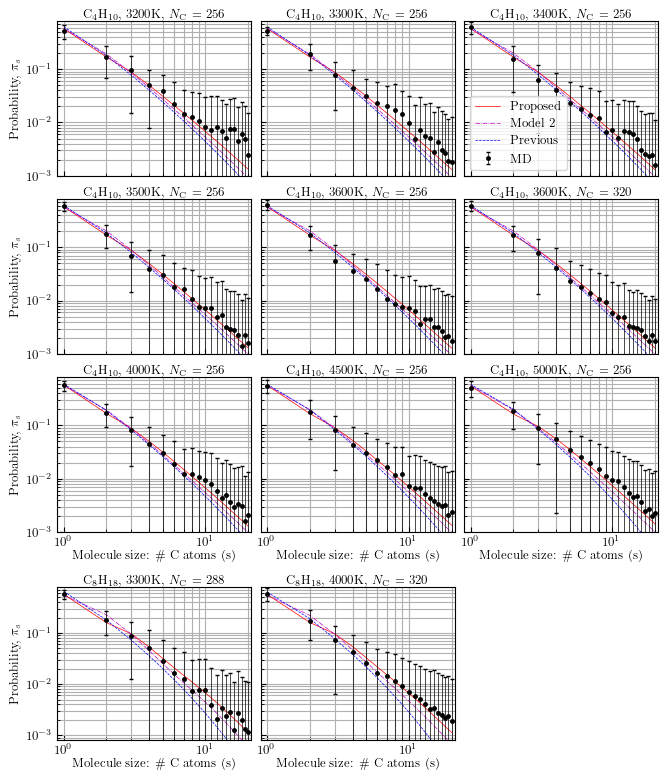

In [11]:
### plot small component size distribution C4H10, C8H18 ###
fig = plt.figure(figsize=(2*col_width,7/3*col_width))
gs = GridSpec(2,1,height_ratios=(0.75,0.225),figure = fig)

gs0 = mpl.gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=gs[0],hspace=.15,wspace=0.05)
gs1 = mpl.gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=gs[1],wspace=0.05)

for i,idx in enumerate(['C4H10_3200K','C4H10_3300K','C4H10_3400K',
                        'C4H10_3500K','C4H10_3600K','C4H10_3600K_1120at',
                        'C4H10_4000K','C4H10_4500K','C4H10_5000K',
                        'C8H18_3300K','C8H18_4000K_1040at']):
    pos = (i//3, i%3)
    if pos[0] < 3:      ax = fig.add_subplot(gs0[pos])      # c4h10
    else:               ax = fig.add_subplot(gs1[pos[1]])   # c8h18

    Avg_MD = component_data['CompSizeDist'].loc[idx][1:21]
    Std_MD = component_data['CompSizeStd'].loc[idx][1:21]
    Std_MD /= sum(Avg_MD)
    Avg_MD /= sum(Avg_MD)

    plt.plot(range(1,21),SmallComps_df.loc[idx,'Proposed_dist'],'-r',lw=.5)
    plt.plot(range(1,21),SmallComps_df.loc[idx,'DisLoop_dist'],'-.m',lw=.5)
    plt.plot(range(1,21),SmallComps_df.loc[idx,'10RM_dist'],'--b',lw=.5)
    ax.errorbar(range(1,21),Avg_MD,Std_MD*2,color='k',marker='.',linestyle='None',capsize=1.5,linewidth=.5,markersize=5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid('on','both')

    if pos[1] == 0:     ax.set_ylabel('Probability, $\pi_s$')
    else:               ax.set_yticklabels([])

    Nc,temp = int(global_data_avg.loc[idx,'Nc']),int(global_data_avg.loc[idx,'Temp'])
    ax.set_xlim([0.9,21])
    if pos[0] < 3:
        ax.set_title(r'${\rm C}_4{\rm H}_{10}$, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)      
        ax.set_ylim([1e-3,8e-1])
        if pos[0] == 2: ax.set_xlabel('Molecule size: \# C atoms (s)',labelpad=1)
        else:           ax.set_xticklabels([])
    else:
        ax.set_title(r'${\rm C}_8{\rm H}_{18}$, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)
        ax.set_xlabel('Molecule size: \# C atoms (s)',labelpad=1)
        ax.set_ylim([8e-4,8e-1])

    if pos == (0,2): ax.legend(['Proposed','Model 2','Previous','MD'],loc='lower left')

plt.tight_layout()
plt.savefig('../../Figures/Components/SmallCompDistC4C8.pdf')

### Small component size distribution of ${\rm C}_2{\rm H}_6$, ${\rm CH}_4$, and mix data

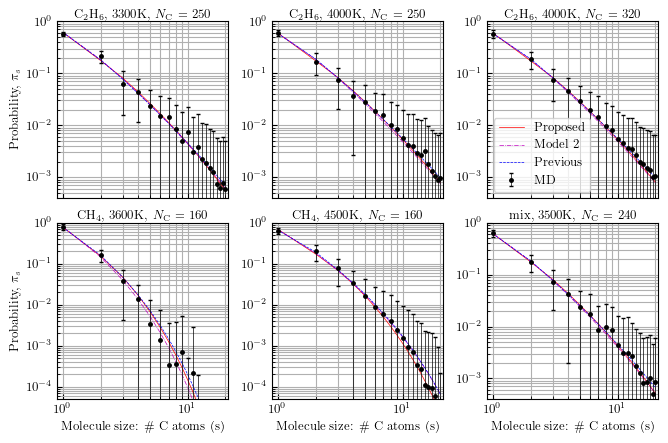

In [12]:
### Histograms for the giant connected component for C2H6, CH4 and mix ###
fig = plt.figure(figsize=(2*col_width,4/3*col_width))
gs = GridSpec(2,3,figure = fig)

for i,idx in enumerate(['C2H6_3300K','C2H6_4000K','C2H6_4000K_1280at',
                        'CH4_3600K','CH4_4500K','mix_3500K']):
    pos = (i//3, i%3)
    ax = fig.add_subplot(gs[pos])

    Avg_MD = component_data['CompSizeDist'].loc[idx][1:21]
    Std_MD = component_data['CompSizeStd'].loc[idx][1:21]
    Std_MD /= sum(Avg_MD)
    Avg_MD /= sum(Avg_MD)

    plt.plot(range(1,21),SmallComps_df.loc[idx,'Proposed_dist'],'-r',lw=.5)
    plt.plot(range(1,21),SmallComps_df.loc[idx,'DisLoop_dist'],'-.m',lw=.5)
    plt.plot(range(1,21),SmallComps_df.loc[idx,'10RM_dist'],'--b',lw=.5)
    ax.errorbar(range(1,21),Avg_MD,Std_MD*2,color='k',marker='.',linestyle='None',capsize=1.5,linewidth=.5,markersize=5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid('on','both')
    
    if pos[1]==0: ax.set_ylabel(r'Probability, $\pi_s$')

    Nc,temp = int(global_data_avg.loc[idx,'Nc']),int(global_data_avg.loc[idx,'Temp'])
    ax.set_xlim([0.9,21])
    if pos[0] == 0:
        ax.set_xticklabels([])
        ax.set_ylim([4e-4,1])
        ax.set_title(r'${\rm C}_2{\rm H}_6$, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)
    else:
        ax.set_xlabel('Molecule size: \# C atoms (s)')
        if pos[1]==2:
            ax.set_ylim([4e-4,1])
            ax.set_title(r'mix, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)
        else:
            ax.set_ylim([5e-5,1])
            ax.set_title(r'${\rm C}{\rm H}_4$, '+str(temp)+r'K, $N_{\rm C}$ = '+str(Nc),fontsize=9,pad=2)

    if pos == (0,2): ax.legend(['Proposed','Model 2','Previous','MD'],loc='lower left')

plt.tight_layout()
plt.savefig('../../Figures/Components/SmallCompDistCC2mix.pdf')
